<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:285%;">
     <b> HOMEWORK 2: </b> <br>
         Wisconsin Breast Cancer Database
    </h1></td>
    <td width="30%">
    <div style="text-align: right">
    <b> Machine Learning</b> <br>
    <b> Lara Colombo </b><br>
    <b>matr. 995885<br>
    <b>c.p. 10650585 <br> 
  <a href="mailto:lara.colombo@mail.polimi.it">lara.colombo@mail.polimi.it</a><br>  
    
</tr>
</table>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy.stats as stats
import scipy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from collections import OrderedDict
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import itertools
from scipy.stats import t, f, norm, zscore
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

np.random.seed(0)

# DATA DESCRIPTION AND EXPLORATIVE ANALYSIS #

The Wisconsin Breast Cancer Database is a collection of data gathered from the clinical observation of breast tissue samples coming from people affected by breast tumor. 
The purpose of this analysis is predicting the class of breast tumor (benign or malignant) given certain characteristics of the samples. 

First, I needed to load the dataset and name the columns:

In [2]:
df = pd.read_csv("breast-cancer-wisconsin.data", header = None, na_values = '?') # loading the dataset

df.columns = ['Sample_code_number', 'Clump_Thickness', 'Uniformity_Cell_Size', 'Uniformity_Cell_Shape',
              'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli',              
              'Mitoses', 'Class']

df = df.drop("Sample_code_number", axis =1)

df.head()
df.shape

,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2


(699, 10)

As can be seen by the head of the dataframe and by the following command, for each variable the values range from 1 to 10. This is because the clinicians who evaluated the samples described each feature by assigning an index in the 1-10 interval: as the value of the index increases, the characteristic of the sample associated to the feature increases too. 

In [3]:
# finding the unique values in each variable 

df_values = {}
for column in df:
    df_values[column] = np.unique(df[column])
df_values

# only bare nuclei has null values

{'Clump_Thickness': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'Uniformity_Cell_Size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'Uniformity_Cell_Shape': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'Marginal_Adhesion': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'Single_Epithelial_Cell_Size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'Bare_Nuclei': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'Bland_Chromatin': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'Normal_Nucleoli': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'Mitoses': array([ 1,  2,  3,  4,  5,  6,  7,  8, 10]),
 'Class': array([2, 4])}

We see that there are some null values that are present in the variable "Bare Nuclei". Since only 16 samples out of 699 were affected by missing observations, I thought it was better to remove them:

In [4]:
print(f'The number of null values in the dataset is: {df[df.isna().any(axis=1)].shape[0]}')

df = df.dropna()
df.shape # final shape without NaN

The number of null values in the dataset is: 16


(683, 10)

Then, I checked the frequency of the two different classes that had to be predicted: 

In [5]:
# coding the values of the class to 0-1

df["Class"] = df["Class"].replace(2,0) # BENIGN -- 0
df["Class"] = df["Class"].replace(4,1) # MALIGNANT -- 1

print(f'The number of BENIGN tumor samples is: {len(df[df["Class"] ==0])}, with a frequency of {len(df[df["Class"] ==0]) / df.shape[0]}')
print(f'The number of MALIGN tumor samples is: {len(df[df["Class"] ==1])}, with a frequency of {len(df[df["Class"] ==1]) / df.shape[0]}')

The number of BENIGN tumor samples is: 444, with a frequency of 0.6500732064421669
The number of MALIGN tumor samples is: 239, with a frequency of 0.34992679355783307


The dataset turned out to be unbalanced, since the class distribution is unequal: the malignant tumor class is far more frequent than the benign one, and therefore there is a consistent bias toward the 0 label. However, this kind of bias is recurrent everytime data regards a clinical condition in which the frequency of the event (disease) is normally way lower than the frequency of the non-event (healthy status). Nevertheless, this bias still has to be handled to make correct predictions. 

## DATA CORRELATION AND ASSOCIATION ###

The first approach that I used to analyze the dataset was investigating the relationships between variables from a descriptive point of view. 

In fact, I computed a pairplot to show how the features were correlated: in this kind of plot, all variables are plotted against each other, while on the diagonal the univariate distribution of each feature is displayed. I also highlighted the class each sample belonged to, in order to catch some putative interesting trend. 

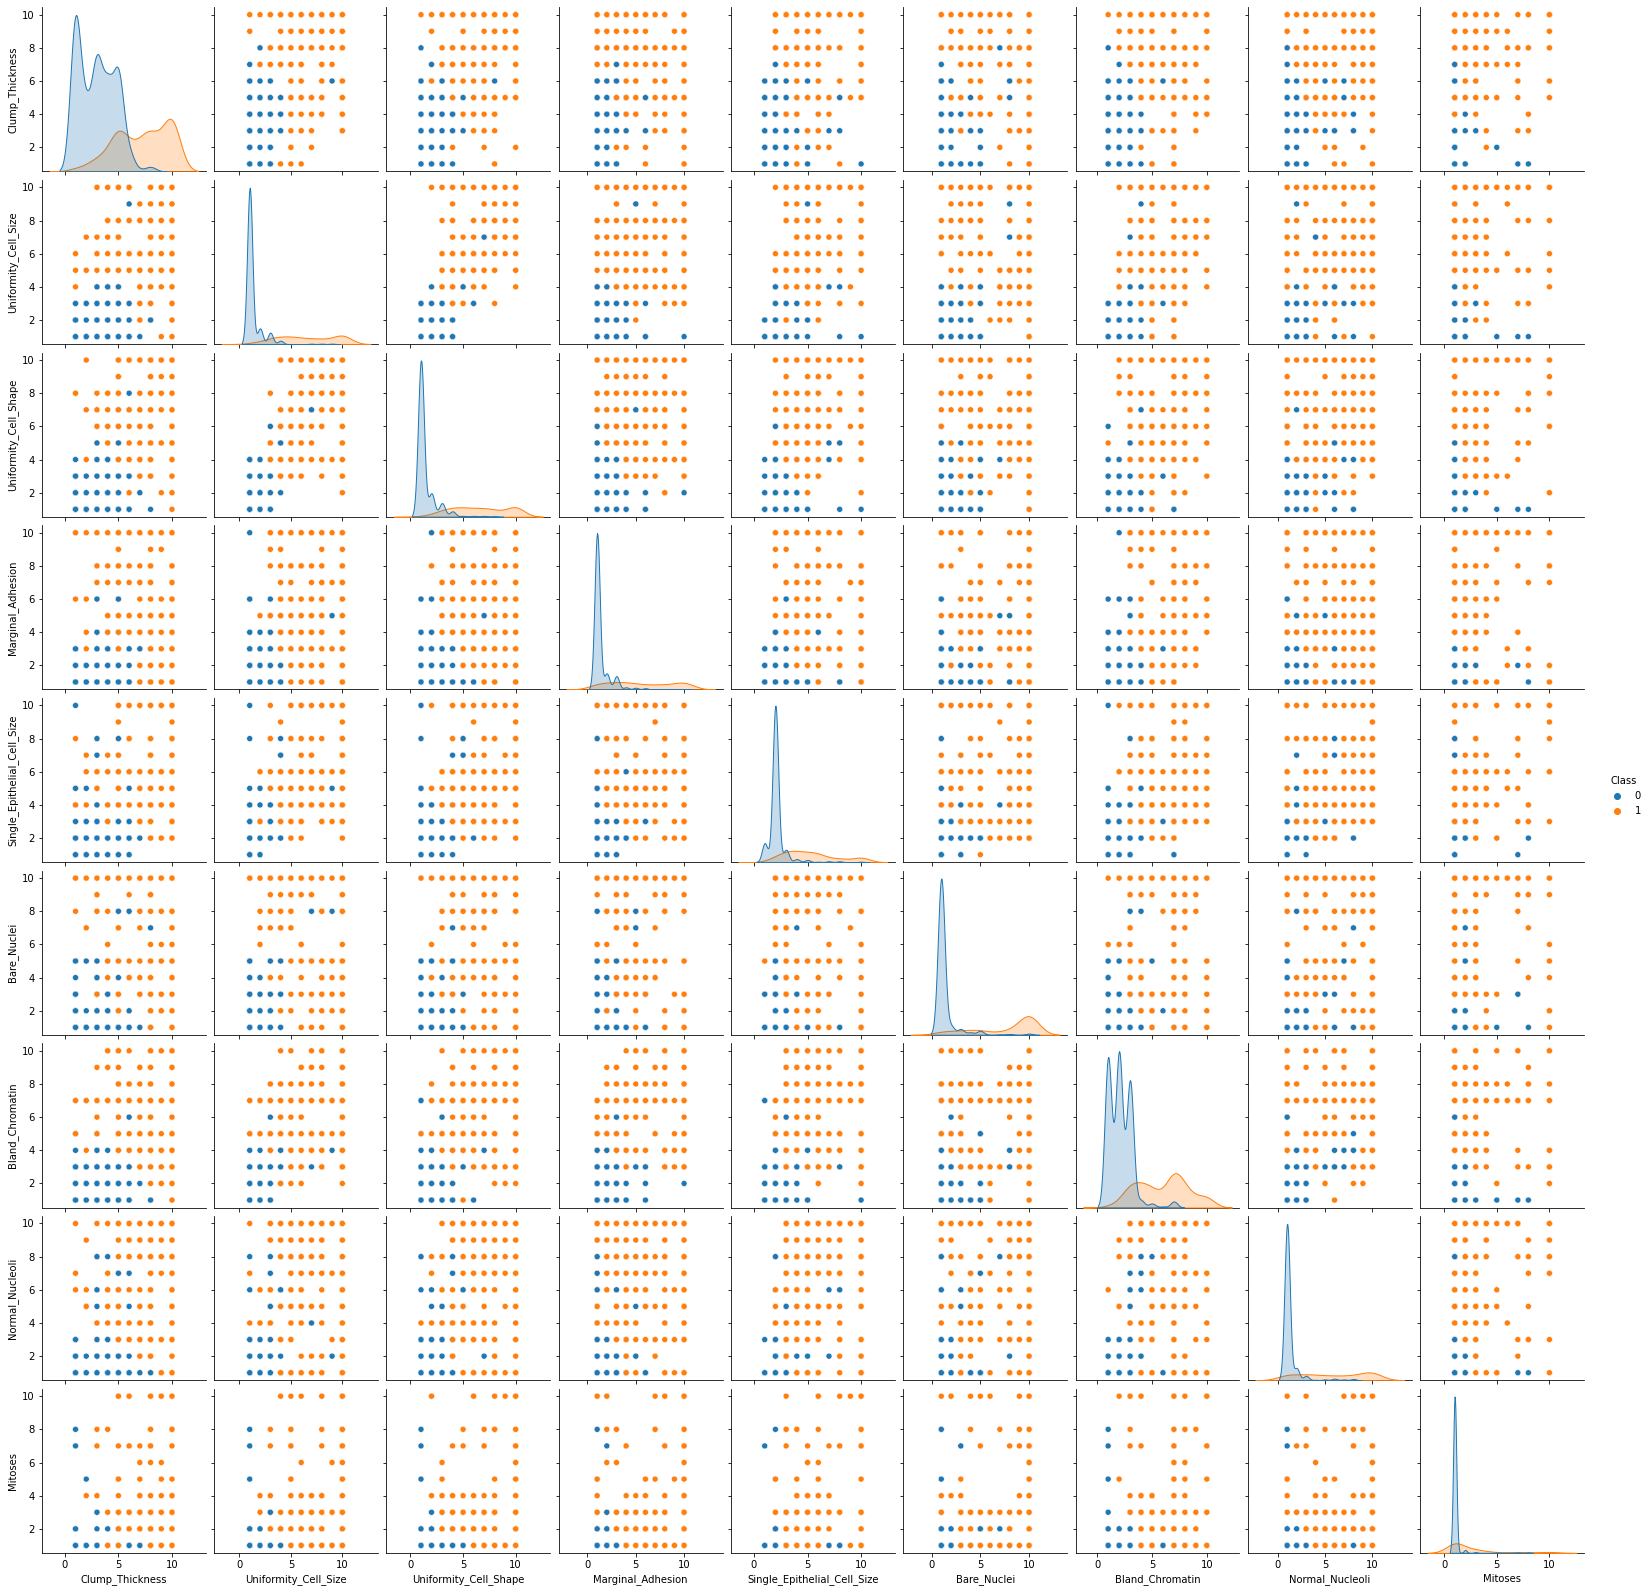

In [6]:
sns.pairplot(df, hue='Class', height=2.5)

At first glance, it can be noticed both from the density plots on the diagonal and from the scatterplots that most of the samples classified as 0 have small values of indices in most of the variables, while the samples classified as 1 tend to have higher values. 
Moreover, it seems that distribution of the data is complex and that the two classes might not be linearly separable. 

Then, I summarized the distribution of the data by plotting two boxplots (which facilitate the comparison between the features) for each variable: one describing the distribution of its samples classified as 0, and the other describing the distribution of its samples classified as 1.

<AxesSubplot:xlabel='variable', ylabel='value'>

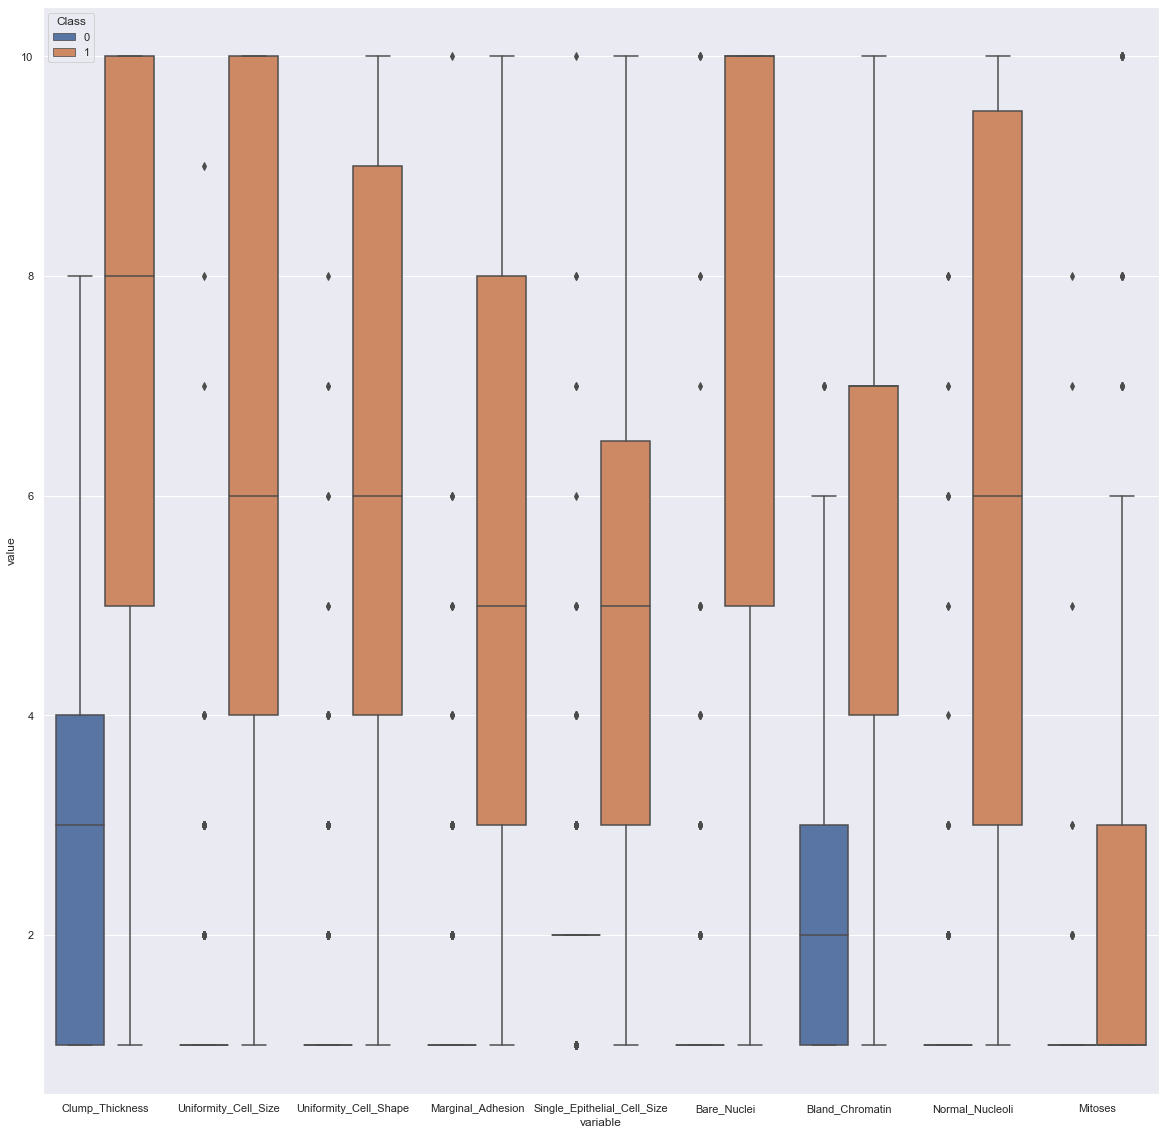

In [7]:
sns.set(rc={'figure.figsize':(20,20)})

sns.boxplot(data = df.melt(var_name = "variable", value_name='value', value_vars=[x for x in df if x != "Class"], id_vars = ['Class']), x = 'variable', y = 'value', hue = 'Class')

It's clear that, regarding all the features, the samples classified as 0 tend to have lower indices compared to the samples classified as 1: some variables do not even display the boxplot related to the class-0 samples, meaning that almost all these observations have an index of 1 (or 2, in the case of Single Epithelial Cell Size) for these features, and therefore mean, median, first and third quartile are all equal to 1 while the other values are determined to be outliers by the plotting function. 

I checked this assertion by looking at some descriptive statistic of the variables, that seem to support the hypothesis: 

In [8]:
df[df['Class'] == 0].describe().T # summary statistics for the samples labaled as 0
df[df['Class'] == 1].describe().T # summary statistics for the samples labaled as 1

,count,mean,std,min,25%,50%,75%,max
Clump_Thickness,444.0,2.963964,1.672661,1.0,1.0,3.0,4.0,8.0
Uniformity_Cell_Size,444.0,1.306306,0.855657,1.0,1.0,1.0,1.0,9.0
Uniformity_Cell_Shape,444.0,1.414414,0.957031,1.0,1.0,1.0,1.0,8.0
Marginal_Adhesion,444.0,1.346847,0.917088,1.0,1.0,1.0,1.0,10.0
Single_Epithelial_Cell_Size,444.0,2.108108,0.877112,1.0,2.0,2.0,2.0,10.0
Bare_Nuclei,444.0,1.346847,1.177848,1.0,1.0,1.0,1.0,10.0
Bland_Chromatin,444.0,2.083333,1.062299,1.0,1.0,2.0,3.0,7.0
Normal_Nucleoli,444.0,1.261261,0.954606,1.0,1.0,1.0,1.0,8.0
Mitoses,444.0,1.065315,0.509738,1.0,1.0,1.0,1.0,8.0
Class,444.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


,count,mean,std,min,25%,50%,75%,max
Clump_Thickness,239.0,7.188285,2.437907,1.0,5.0,8.0,10.0,10.0
Uniformity_Cell_Size,239.0,6.577406,2.724244,1.0,4.0,6.0,10.0,10.0
Uniformity_Cell_Shape,239.0,6.560669,2.569104,1.0,4.0,6.0,9.0,10.0
Marginal_Adhesion,239.0,5.585774,3.196631,1.0,3.0,5.0,8.0,10.0
Single_Epithelial_Cell_Size,239.0,5.326360,2.443087,1.0,3.0,5.0,6.5,10.0
Bare_Nuclei,239.0,7.627615,3.116679,1.0,5.0,10.0,10.0,10.0
Bland_Chromatin,239.0,5.974895,2.282422,1.0,4.0,7.0,7.0,10.0
Normal_Nucleoli,239.0,5.857741,3.348876,1.0,3.0,6.0,9.5,10.0
Mitoses,239.0,2.602510,2.564495,1.0,1.0,1.0,3.0,10.0
Class,239.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In addition to this, I also plotted the frequency of each unique value for each feature, divided by class:

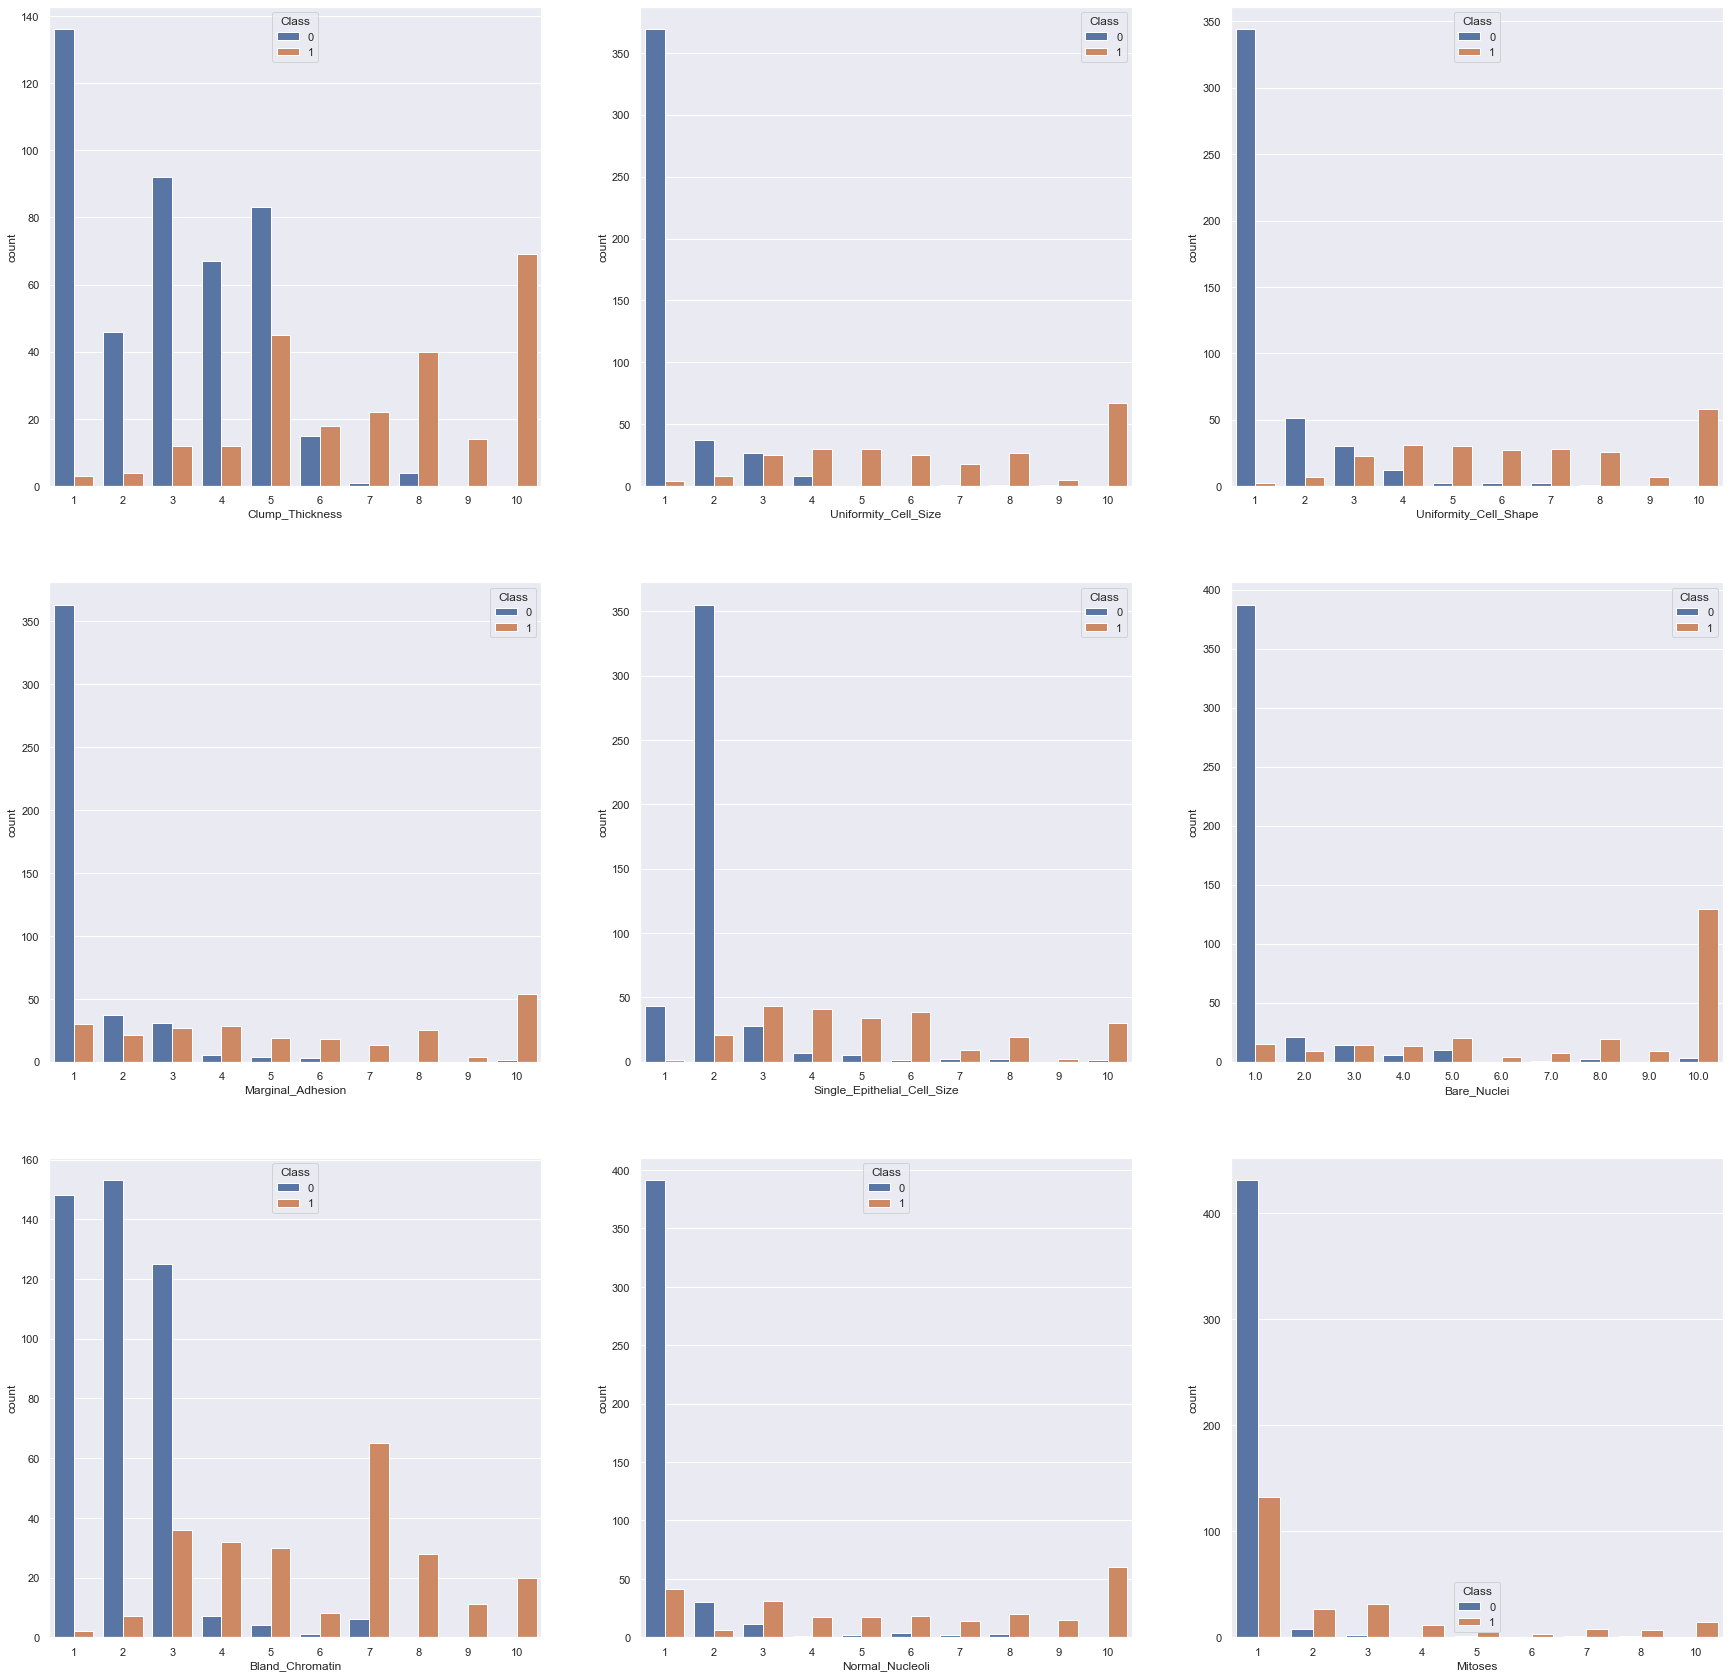

In [9]:
sns.set(rc={'figure.figsize':(30,30)})

n = 1
for var in df.columns:
    if var != 'Class':
        _ = plt.subplot(3,3,n)
        _ = sns.countplot(x = df[var], hue = df['Class'])
        n +=1

which confirmed that some variables have almost only index of 1 for the samples classified as 0. 
Generally speaking, it seems that benign tumor samples tend to have values of indices below 5. On the contrary, samples classified as 1 tend to present higher indeces. 

This trend can be asserted also from the frequency of each index in the malignant class samples population,   grouped by features:

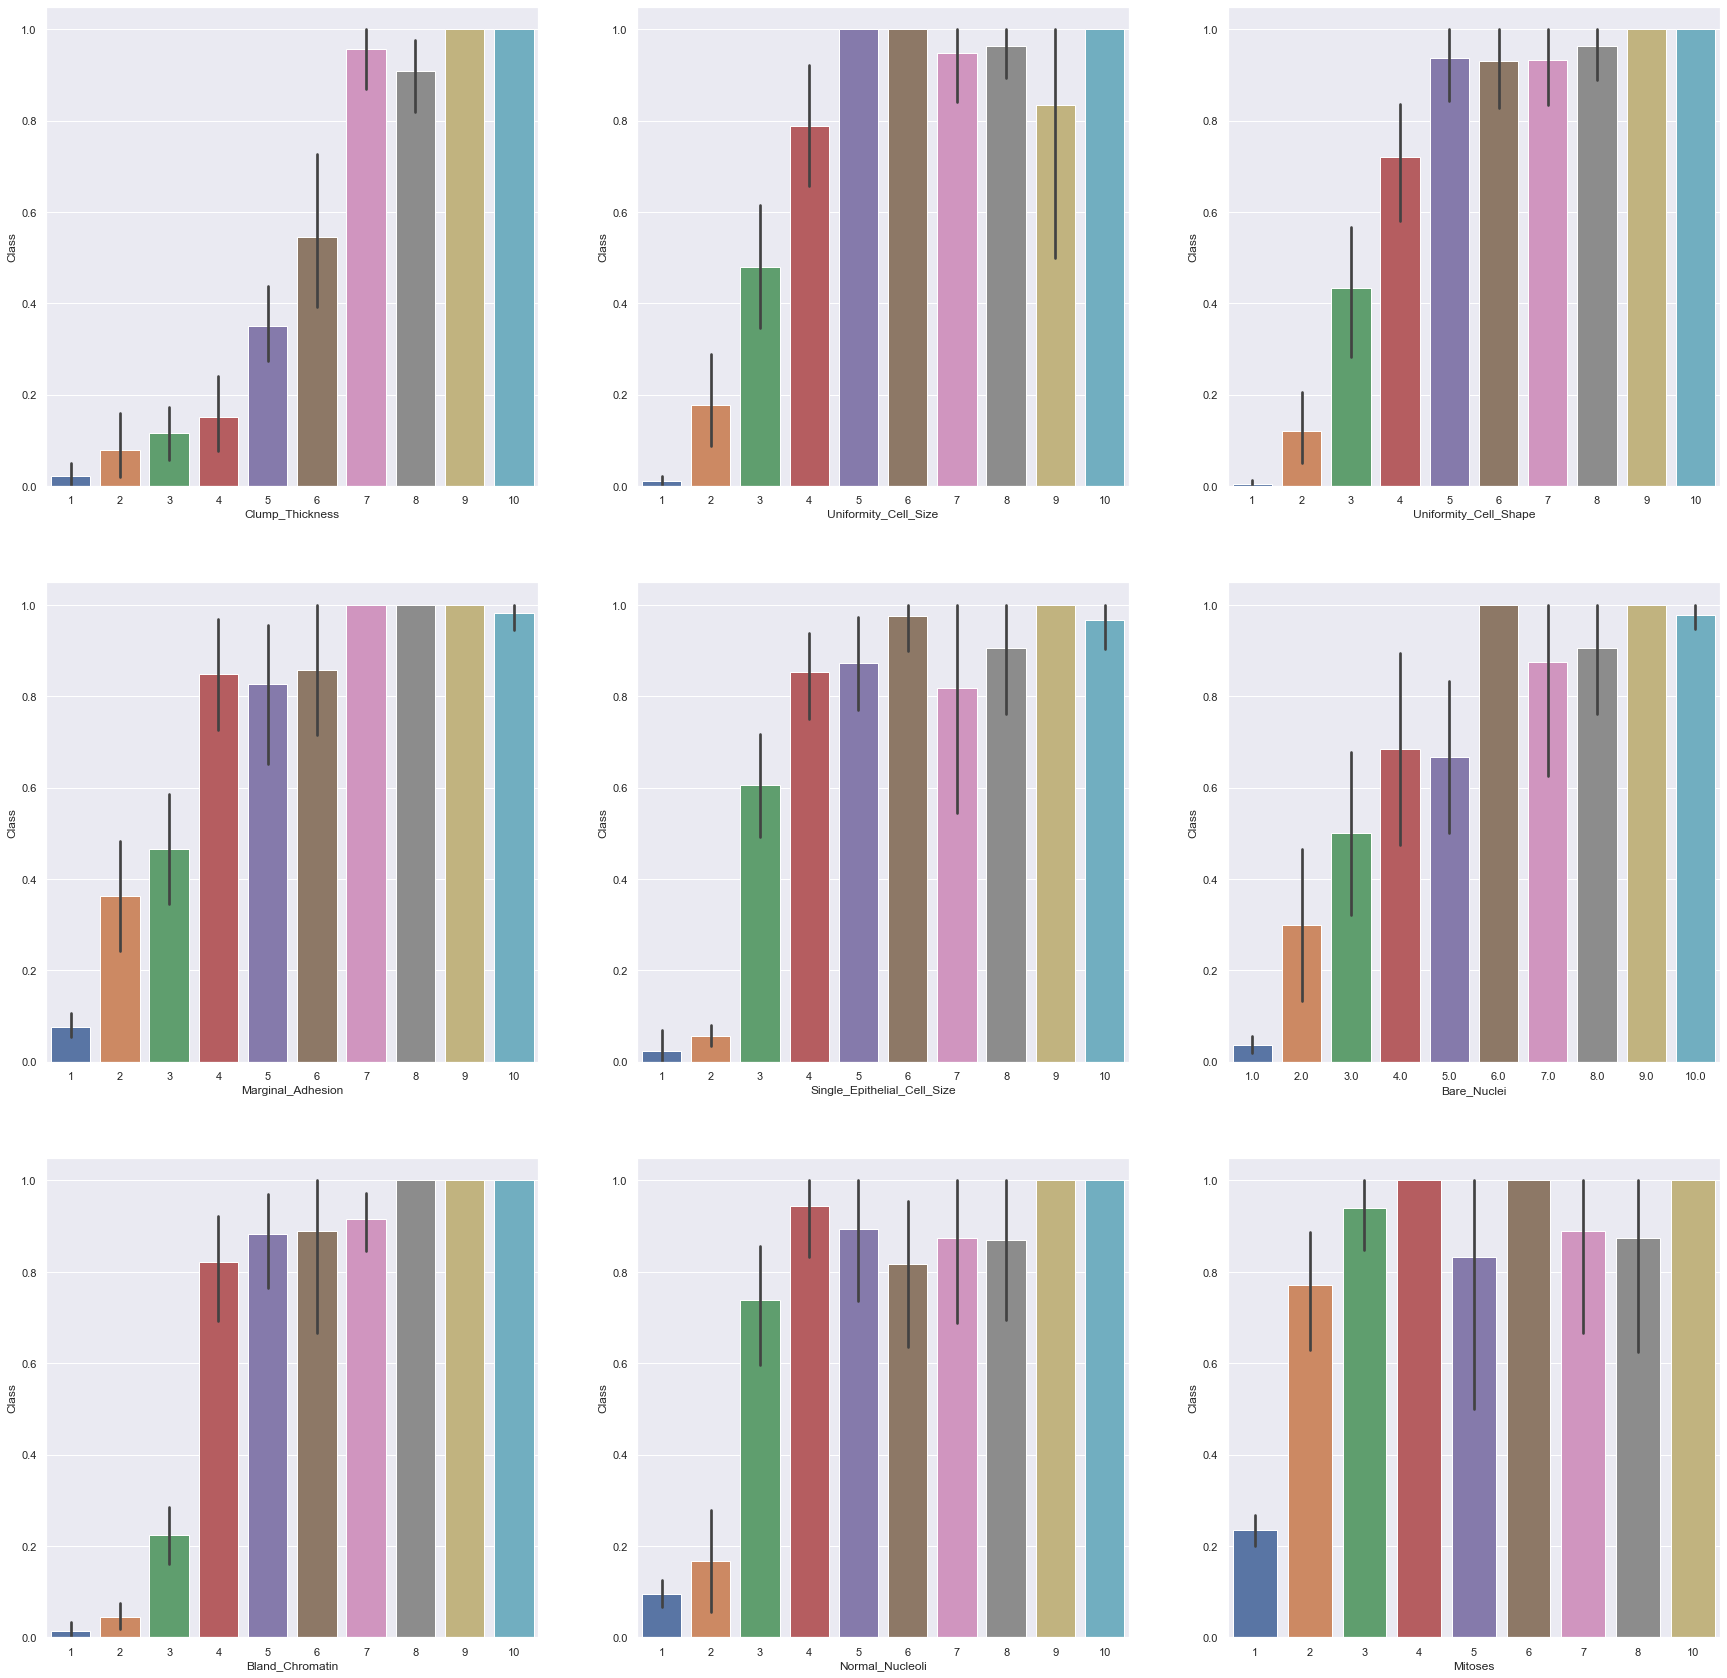

In [10]:
n = 1
for var in df.columns:
    if var != 'Class':
        _ = plt.subplot(3,3,n)
        _ = sns.barplot(x = df[var], y = df['Class']) 
        n += 1

The probability of being classified as 1 seems to increase when considering values of indeces above 4 or 5, depending on the feature taken into consideration.  

Eventually, I checked how the different variables were associated with the class and each other by plotting a correlation matrix:

<AxesSubplot:>

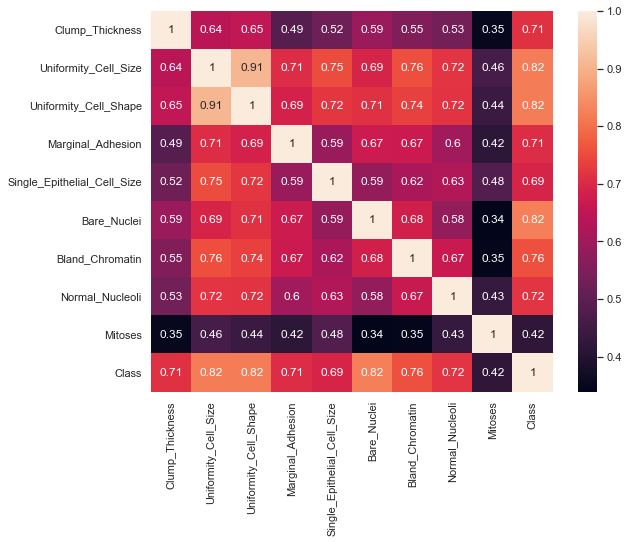

In [11]:
sns.set(rc={'figure.figsize':(9,7)})

sns.heatmap((df).corr(), annot = True)

The cell size and shape features clearly showed to be highly correlated, which could have been predictable since it makes sense also from a biological point of view. In addition to that, most of the variables seem to show a pretty significant correlation with each other and also with the predicted class, and this is clearly due to the nature of the data: in fact, the types of observations stored in this dataset describe specific tissue conditions of tumor samples, and therefore the characteristics of the nucleus and the cellular membrane are expected to change from the benign to the malignant status as this clinical classification is usually derived from such histological differences. 

# CLASSIFICATION ANALYSIS

As said before, the purpose of this analysis was predicting the type of tumor of each sample given the histological features collected by clinicians. Since the class of tumor (benign and malignant) is a categorical variable, the best approach for estimating the response is classification: in this setting, predicting the class of tumor means estimating the probability of a sample to be a malignant tumor tissue given these oberservations. 

Classification can be distinguished between linear and non-linear, depending on the type of boundary that is able to divide one class from the other in the feature space. Since there are 9 features taken into consideration, the feature space is too complex to catch linearity from plots: therefore, I though that applying different classification techniques and evaluating their performances would be the safer way to find the best classifier. 

### DATA PRE-PROCESSING - Considerations ###

Usually, when dealing with methods that estimate the significance of a feature in predicting the outcome, variables are normalized so that all values span on the same range and therefore the different scale does not influence their relevance in the prediction: this is particularly important when fitting classification methods that rely on sample distances to estimate probabilities. However, in this dataset all variables are already set on the same scale since features are described by an index ranging from 1 to 10. Therefore, I thought that scaling or normalizing was not particularly necessary in this situation: for example, regarding range normalization, making all features have values between [0,1] would have simply meant to multiply everything by 0.1, and that wouldn't have changed the relationship between variables.

## LOGISTIC REGRESSION

The first attempt that I made was fitting the Logistic classifier.

Logistic Regression is a technique that models the posterior probability of the class (p(X)) by regressing the logistic function. 
In this setting, the decision boundary that divides one class from the other is a linear monotone transformation of the posterior probabilities and is made of a set of points for which the log-odds (the logarithm of p(X) / (1-p(X)) are zero. This is both the strength and the limit of this classifier: it is surely easy to understand and interpret, but data must be linearly separable for the model to work properly. 

First, I splitted the data in a training set (on which the model will be computed) and in a testing set (on which the performance of the model will be furtherly evaluated to be sure that it did not overfit the training data). The stratify parameter was added to the 'train_test_split' method to keep the dataset proportions of malignant and benign tumor samples also in the train and test sets, in order to make the analysis as reliable as possible without any source of bias:

In [12]:
x_features = [x for x in df.columns if x != 'Class']
x = df[x_features]
y = df['Class'].to_numpy()

split_seed = 42
split_test_size = 0.3

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=split_test_size, 
                                                    random_state=split_seed, stratify = y)

In [13]:
# checking that training and test set maintain the same proportion:

print(f'The frequency of BENIGN tumor samples in the train set is is: {len(y_train[y_train == 0]) / y_train.shape[0]}')
print(f'The frequency of MALIGNANT tumor samples in the train set is is: {len(y_train[y_train == 1]) / y_train.shape[0]}')
print(f'The number of BENIGN tumor samples in the test set is: frequency of {len(y_test[y_test ==0]) / y_test.shape[0]}')
print(f'The number of MALIGN tumor samples in the test set is: frequency of {len(y_test[y_test ==1]) / y_test.shape[0]}')

The frequency of BENIGN tumor samples in the train set is is: 0.6506276150627615
The frequency of MALIGNANT tumor samples in the train set is is: 0.3493723849372385
The number of BENIGN tumor samples in the test set is: frequency of 0.6487804878048781
The number of MALIGN tumor samples in the test set is: frequency of 0.35121951219512193


To fit the logistic classifier, I took advantage of a scikit-learn module: 

In [14]:
lr = LogisticRegression(solver="newton-cg", penalty='none') # solver: algorithm used in the optimization problem (maximization of the likelihood function) 
_ = lr.fit(x_train, y_train)

To test the performances of the model, different metrics can be employed: in the classification setting there are various scores that can be used depending on the purpose of the analysis. In fact, since the outcome of the prediction is basically a label (assigned after the estimation of a probability), there are mainly two types of error that can occur and that have to be managed: 
- being assigned to class 1 when the true class is 0 (or false positives - FP) 
- being assigned to class 0 when the true class 1 ( or false negatives - FN)

Different classification metrics evaluate the performance of the model giving more or less importance to its ability to minimize false negative discoveries compared to false positive discoveries, or conversely; there are some metrics that instead evaluate the balance of the two. 

In the medical and clinical context, when the predicted class is usually about a health status, it isn't much useful to rely only on the overall error rate, because it will always favour the classifier tha predicts the most common class if the data is unbalanced - as it usually happens in the screening of a disease, since true positives are far less common than true negatives, but more urgent to identify to prevent the progression of the disease; this means that it is essential to catch all possible true positives, and therefore to avoid false negatives. 
This situation is very similar to the case into analysis, because, as I mentioned before, the malignant tumor samples - which urge to be predicted - make only the 35% of the dataset.

Therefore, I used two different metrics to evaluate models: 
- sensitivity (or recall), that is the ability to correctly identify all the positives samples (in this case, the malignant tumor class)
- accuracy, that measures the proportion of correct true positives and true negatives predictions among the total number of cases examined

I computed the accuracy metric supporting the recall metric because I needed to control that sensitivity alone didn't reward a model that erroneously assigned too many positive labels, surely increasing the true positive rate but increasing the false positive rate too (false positives are not really an issue in this context because can be easily revealed by further analyses, but the model still needs to have a proper level of accuracy). 

The accuracy metric that I used was defined as follows, while to compute sensitivity I employed a scikit-learn method:

In [15]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()

In [16]:
print("Train accuracy:", accuracy(y_train, lr.predict(x_train)))
print("Train recall:", sklearn.metrics.recall_score(y_train, lr.predict(x_train)))
print("Test accuracy:", accuracy(y_test, lr.predict(x_test)))
print("Test recall:", sklearn.metrics.recall_score(y_test, lr.predict(x_test)))

Train accuracy: 0.9769874476987448
Train recall: 0.9640718562874252
Test accuracy: 0.9560975609756097
Test recall: 0.9444444444444444


This model seems to have good performances regarding both accuracy and sensitivity scores, but its ability in identifying true positives might be improved, especially if considering the recall score obtained on the test set. To have a grasp of the meaning of these scores in describing the model performances, a confusion matrix can be displayed:

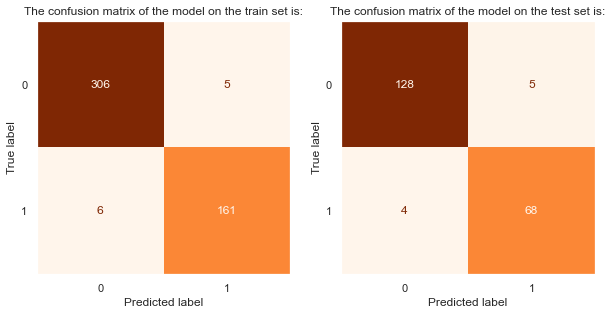

In [17]:
sns.set(rc={'figure.figsize':(10,10)})

cm = confusion_matrix(y_test, lr.predict(x_test))

# train confusion matrix

ax1 = plt.subplot(1,2,1)

_ = plt.title(f'The confusion matrix of the model on the train set is:')
_ = plot_confusion_matrix(lr, x_train, y_train, ax = ax1, colorbar = False, cmap= 'Oranges')
plt.grid(False)

# test confusion matrix   

ax2 = plt.subplot(1,2,2)
_ = plt.title(f'The confusion matrix of the model on the test set is:')
_ = plot_confusion_matrix(lr, x_test, y_test, ax = ax2, colorbar = False, cmap= 'Oranges')
plt.grid(False)

With this model, almost 6% of positive samples are predicted to be negative in the test set, which is something to be avoided when screening for a frequent and malignant tumor that can be safely healed if diagnosed early, such as breast cancer. The sensibility of this model surely has to be improved. 

### FEATURES SELECTION ###

I therefore tried to fix the performances of the model by testing if all features were actually significant to classify the samples: removing useless variables could have improved the fitting on the test set, avoiding a possible overfitting on the train set.  
The most appropriate test of significance that could be applied in this context was the Z-test, because of the approximatively normal distribution of the difference between the true parameters and their estimates. 
I applied this test with a significance level of 0.05, as this analysis was just meant to be explorative:

In [18]:
def z_test(X, y, model, names, alpha=None):
    n_samples, n_features = X.shape
    betas = np.concatenate([model.intercept_, model.coef_.reshape(-1)])
    
    # Compute the prediction
    pred = model.predict_proba(X) 
    y = y.reshape(-1)    
    X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    n_samples, n_features = X.shape
    
    V = np.diagflat(np.product(pred, axis = 1)) 
    covLogit = np.linalg.inv(np.dot(np.dot(X.T, V), X)) 
    se_b = np.sqrt(np.diag(covLogit))
    
    z_stat_b = (betas-0)/se_b

    # Compute the p-value (two-sided test)
    p_values = np.array([2 * norm.sf(np.abs(z_stat)) for z_stat in z_stat_b])
    
    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = np.round(se_b, decimals=4)
    df["Z-stat"] = np.round(z_stat_b, decimals=1)
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0    
    
    return df

z_test(x_train, y_train, lr, ["Intercept", *x_features], alpha=0.05)

,Name,Coefficients,Standard Errors,Z-stat,p-value,reject H0
0,Intercept,-11.067714,1.7482,-6.3,2.435595e-10,True
1,Clump_Thickness,0.519762,0.1848,2.8,4.922158e-03,True
2,Uniformity_Cell_Size,0.297884,0.3691,0.8,4.196841e-01,False
3,Uniformity_Cell_Shape,0.318979,0.4096,0.8,4.361209e-01,False
4,Marginal_Adhesion,0.295986,0.1631,1.8,6.952825e-02,False
5,Single_Epithelial_Cell_Size,0.190249,0.2123,0.9,3.702208e-01,False
6,Bare_Nuclei,0.643503,0.1527,4.2,2.508481e-05,True
7,Bland_Chromatin,0.128849,0.2399,0.5,5.912353e-01,False
8,Normal_Nucleoli,0.188209,0.1560,1.2,2.275622e-01,False
9,Mitoses,0.713280,0.3282,2.2,2.975578e-02,True


The results of the Z-test are very meaningful from a biological point of view: the features that seem to be significant in the prediction at level alpha = 0.05 are the ones associated with cell replication or degeneration, which makes sense considering the tumor biology. 

However, other techniques of feature selection are surely more reliable because they take into account also the number of variables employed in the model, while the Z-test doesn't. In addition to that, the Z-test is really influenced by the seed, while other types of feature selection are more robust.

Therefore, I performed the selection of the most significant variables that might improve the performance of the model - and its interpretabilty too - also by applying the Lasso penalization (defined as lambda), which is able to shrink the coefficients associated to the features: high enough values of lambda can even set parameters to zero. It is a way to perform feature selection because the more significant a feature is, the higher the penalization has to be to set its coefficient to zero. 
The scikit-learn Logistic Regression method has a penalty term that applies the Lasso shrinkage if set to 'l1'.

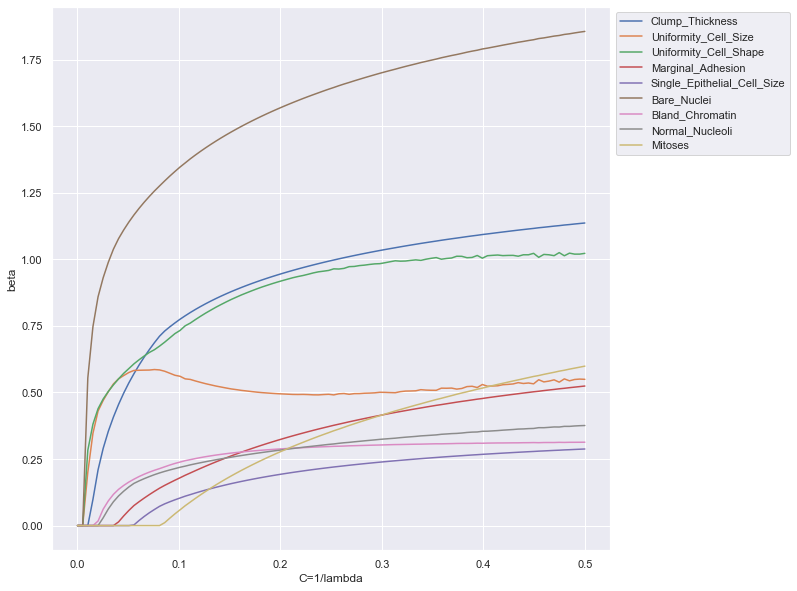

In [19]:
C_vals = np.linspace(1e-4, 0.5, 100) # this parameter opposite of lambda: smaller values apply a stronger regularization
betas = []

from sklearn import preprocessing
X_std = preprocessing.scale(x_train) # normalization of the data: ensures parameters are within the same ranges for different penalization values

for C in C_vals:
    model = LogisticRegression(solver='saga', penalty='l1', C=C)
    model.fit(X_std, y_train)
    beta = model.coef_.reshape(-1)
    betas.append(beta)
betas = np.stack(betas, axis=1) 

for beta, name in zip(betas, x_features):
    _ = plt.plot(C_vals, beta, label=name)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("C=1/lambda")
plt.ylabel("beta")
_;

This graph displays how coefficients behave for increasing values of lambda (smaller values of C). Interestingly, it looks like 'Uniformity cell size' becomes first less and then more significant in the model when some features are shrunk. 

I then investigated which were the features that went latest to zero, therefore the most important for the prediction: 

In [20]:
# get lasso features, decreasing order: 

features_lasso = {}
for beta, name in zip(betas, x_features): 
    features_lasso.update({name:list(beta).count(0)})

features_lasso = dict(sorted(features_lasso.items(), key=lambda item: item[1]))
features_lasso
print(f'The features selected by Lasso, from the latest that goes to zero to the first, are: {tuple(features_lasso.keys())}')

{'Uniformity_Cell_Size': 2,
 'Uniformity_Cell_Shape': 2,
 'Bare_Nuclei': 2,
 'Clump_Thickness': 3,
 'Bland_Chromatin': 4,
 'Normal_Nucleoli': 5,
 'Marginal_Adhesion': 8,
 'Single_Epithelial_Cell_Size': 11,
 'Mitoses': 17}

The features selected by Lasso, from the latest that goes to zero to the first, are: ('Uniformity_Cell_Size', 'Uniformity_Cell_Shape', 'Bare_Nuclei', 'Clump_Thickness', 'Bland_Chromatin', 'Normal_Nucleoli', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Mitoses')


The Lasso penalization proved that many variables seem to be more significant than some of the features selected by the Z-test, and since this procedure is more robust than hypothesis testing (I checked myself how results changed with different seeds) I decided to rely on the selection by Lasso penalization. 

To find the best, I evaluated 8 different models - skipping the full one, that was already fitted above - by iteratively taking out the features that went to zero first according to the results shown above. 
Each model was tested both with sensitivity and accuracy metrics:

In [21]:
def get_cv_evaluator(scorer, cv= 3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

selected_features = []
scores = []
evaluate = get_cv_evaluator(make_scorer(accuracy), cv = 5)

# ACCURACY 
n = 1
for x in range(8):
    f = list(features_lasso.keys())[:-n]
    z = x_train[f].to_numpy()
    model = LogisticRegression(solver="newton-cg", penalty='none')
    model, score = evaluate(model, z, y_train)                       
    scores.append(score)
    selected_features.append(f)
    n +=1
    
best_idx = np.argmax(scores)
lasso_best_features_accuracy = selected_features[best_idx]
print(f'The best features selected with the accuracy metrics are: {lasso_best_features_accuracy}')

# SENSITIVITY 

selected_features = []
scores = []
evaluate = get_cv_evaluator(make_scorer(sklearn.metrics.recall_score), cv = 5)

n = 1
for x in range(8):
    f = list(features_lasso.keys())[:-n]
    z = x_train[f].to_numpy()
    model = LogisticRegression(solver="newton-cg", penalty='none')
    model, score = evaluate(model, z, y_train)                       
    scores.append(score)
    selected_features.append(f)
    n +=1
    
best_idx = np.argmax(scores)
lasso_best_features_recall = selected_features[best_idx]
print(f'The best features selected with the recall metrics are: {lasso_best_features_recall}')

The best features selected with the accuracy metrics are: ['Uniformity_Cell_Size', 'Uniformity_Cell_Shape', 'Bare_Nuclei', 'Clump_Thickness', 'Bland_Chromatin', 'Normal_Nucleoli', 'Marginal_Adhesion']
The best features selected with the recall metrics are: ['Uniformity_Cell_Size', 'Uniformity_Cell_Shape', 'Bare_Nuclei', 'Clump_Thickness', 'Bland_Chromatin', 'Normal_Nucleoli', 'Marginal_Adhesion']


The two different metrics identified the same model as best, that I therefore fitted to check if its performances improved compared to the full one:

In [22]:
# MODEL CHOSEN BASED ON ACCURACY

x_l = df[lasso_best_features_accuracy] 
y = df['Class'].to_numpy()

x_train_l, x_test_l, y_train, y_test = train_test_split(x_l, y,
                                                    test_size=split_test_size, 
                                                    random_state=split_seed, stratify = y)
X_l = x_train_l.to_numpy()
X_t_l = x_test_l.to_numpy()

lr_lasso = LogisticRegression(solver="newton-cg", penalty='none')  
_ = lr_lasso.fit(X_l, y_train)

print("Train accuracy:", accuracy(y_train, lr_lasso.predict(X_l)))
print("Train recall:", sklearn.metrics.recall_score(y_train, lr_lasso.predict(X_l)))
print("Test accuracy:", accuracy(y_test, lr_lasso.predict(X_t_l)))
print("Test recall:", sklearn.metrics.recall_score(y_test, lr_lasso.predict(X_t_l)))

Train accuracy: 0.9728033472803347
Train recall: 0.9520958083832335
Test accuracy: 0.9609756097560975
Test recall: 0.9583333333333334


    Full model:
    
    Train accuracy: 0.9769874476987448
    Train recall: 0.9640718562874252
    Test accuracy: 0.9560975609756097
    Test recall: 0.9444444444444444

The reduced model got higher scores on the test set, and therefore gained in generalization ability, and now only 4% of true positives in the test set were lost by its prediction:

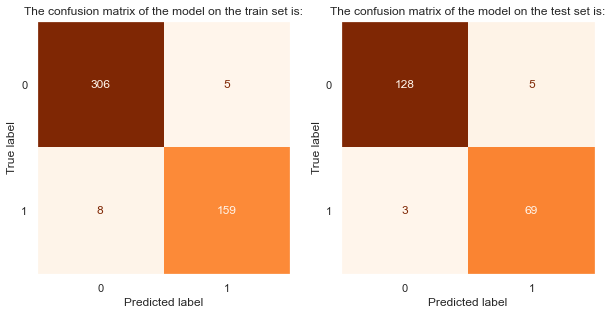

In [23]:
sns.set(rc={'figure.figsize':(10,10)})

cm = confusion_matrix(y_test, lr_lasso.predict(x_test_l))

# train confusion matrix

ax1 = plt.subplot(1,2,1)

_ = plt.title(f'The confusion matrix of the model on the train set is:')
_ = plot_confusion_matrix(lr_lasso, x_train_l, y_train, ax = ax1, colorbar = False, cmap= 'Oranges')
plt.grid(False)

# test confusion matrix

ax2 = plt.subplot(1,2,2)
_ = plt.title(f'The confusion matrix of the model on the test set is:')
_ = plot_confusion_matrix(lr_lasso, x_test_l, y_test, ax = ax2, colorbar = False, cmap= 'Oranges')
plt.grid(False)

However, it still might be preferrable to look for a model with higher sensitivity performances. 

## LINEAR DISCRIMINANT ANALYSIS

I therefore switched to another classification technique: Linear Descriminant Analysis (LDA). 
This classifier differs from the previous one because it estimates the density function of predictors to approximate the Bayes classifier to model p(X), instead of the logistic function. However, to estimate the density function some important assumptions have to be made: 

- the density functions of the predictors are distributed as a multivariate Gaussian
- all classes have a shared variance (and therefore a shared covariance matrix)

These assumptions simplify the problem and allow to model the posterior probability as a linear function of x, and therefore even in this case the decision boundary is linear.

In [24]:
lda = LDA(store_covariance = True)
_ = lda.fit(x_train, y_train)

print("Train accuracy:", accuracy(y_train, lda.predict(x_train)))
print("Train recall:", sklearn.metrics.recall_score(y_train, lda.predict(x_train)))
print("Test accuracy:", accuracy(y_test, lda.predict(x_test)))
print("Test recall:", sklearn.metrics.recall_score(y_test, lda.predict(x_test)))

Train accuracy: 0.9707112970711297
Train recall: 0.9341317365269461
Test accuracy: 0.9365853658536586
Test recall: 0.8888888888888888


Compared to Logistic Regression, this model doesn't seem to have any advantage: 

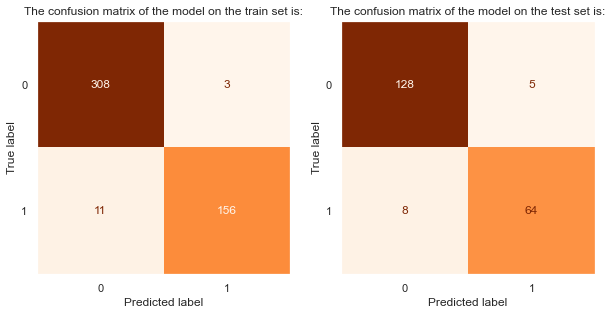

In [25]:
cm = confusion_matrix(y_test, lda.predict(x_test))

# train confusion matrix

ax1 = plt.subplot(1,2,1)

_ = plt.title(f'The confusion matrix of the model on the train set is:')
_ = plot_confusion_matrix(lda, x_train, y_train, ax = ax1, colorbar = False, cmap= 'Oranges')
plt.grid(False)

# test confusion matrix

ax2 = plt.subplot(1,2,2)
_ = plt.title(f'The confusion matrix of the model on the test set is:')
_ = plot_confusion_matrix(lda, x_test, y_test, ax = ax2, colorbar = False, cmap= 'Oranges')
plt.grid(False)

However, it can be improved by adding complexity. 

### LDA WITH POLYNOMIAL FEATURES ### 

We can check if a more complex boundary would better separate the classes, by converting features into polynomial and therefore projecting them into a higher dimensional space (in which the boundary will still be linear, but polynomial if projected back into the original input space). 

The best degree of the polynomial can be found by cross validation and the GridSearch module, which is a scikit-learn function that searches over specified parameter values for an estimator and chooses the most performing according to a metric (decided by the user): in particular, the model that has the best cross-validation score (mean of the metric on each validation set) is chosen. I decided to employ the function with both accuracy and sensitivity scorers to check if the best degree chosen by each metric was different:

In [26]:
lda_poly = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA(store_covariance=True))])
params = {'poly__degree': range(1, 6)}

# 'cv' refers to the model chosen by accuracy 

cv = GridSearchCV(lda_poly, params, refit=True, cv=5, 
                  scoring=make_scorer(accuracy))
_ = cv.fit(x_train, y_train)

# 'cv1' refers to the model chosen by sensitivity

cv1 = GridSearchCV(lda_poly, params, refit=True, cv=5, 
                  scoring=make_scorer(sklearn.metrics.recall_score))
_ = cv1.fit(x_train, y_train)

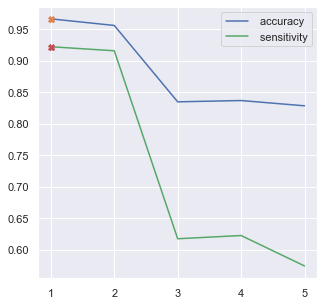

In [27]:
def show_results(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
    #Plot the CV (mean) scores for all possible parameters
    plt.plot(results[params], results['mean_test_score'], label=prefix)
    best_idx = np.argmax(results['mean_test_score'])
    plt.plot(results[params][best_idx],results['mean_test_score'][best_idx],marker='X')
    plt.legend()

sns.set(rc={'figure.figsize':(5, 5)})
show_results(cv, x_test, 'param_poly__degree', 'accuracy')
show_results(cv1, x_test, 'param_poly__degree', 'sensitivity')

However, the best degree selected by GridSearch and cross-validation is 1 for both the metrics, therefore polynomial features would not make any improvement in this setting.   

## QUADRATIC DISCRIMINANT ANALYSIS

Since the poor performances of LDA might be due to its strict assumptions (that were probably not met by this dataset -- even if not drastically, because the model didn't perform terribly --, also considering that if values are discrete, they can hardly be normally distributed), I employed Quadratic Discriminant Analysis (QDA) that gets rid of the assumption of equivalence of the variances. 
By removing this assumption, the decision boundary becomes quadratic, and therefore the flexibility of the model increases:

In [28]:
qda = QDA(store_covariance = True)
_ = qda.fit(x_train, y_train)

print("Train accuracy:", accuracy(y_train, qda.predict(x_train)))
print("Train recall:", sklearn.metrics.recall_score(y_train, qda.predict(x_train)))
print("Test accuracy:", accuracy(y_test, qda.predict(x_test)))
print("Test recall:", sklearn.metrics.recall_score(y_test, qda.predict(x_test)))

Train accuracy: 0.9581589958158996
Train recall: 0.9820359281437125
Test accuracy: 0.9560975609756097
Test recall: 0.9583333333333334


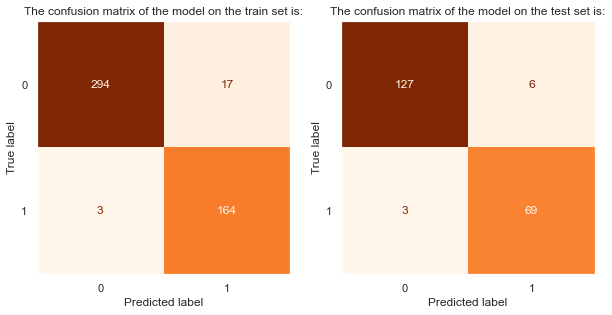

In [29]:
sns.set(rc={'figure.figsize':(10, 10)})

cm = confusion_matrix(y_test, qda.predict(x_test))

# train confusion matrix

ax1 = plt.subplot(1,2,1)

_ = plt.title(f'The confusion matrix of the model on the train set is:')
_ = plot_confusion_matrix(qda, x_train, y_train, ax = ax1, colorbar = False, cmap= 'Oranges')
plt.grid(False)

# test confusion matrix

ax2 = plt.subplot(1,2,2)
_ = plt.title(f'The confusion matrix of the model on the test set is:')
_ = plot_confusion_matrix(qda, x_test, y_test, ax = ax2, colorbar = False, cmap= 'Oranges')
plt.grid(False)

With a more complex boundary, the performance of the model improves really much regarding the recall scores, while still keeping a high accuracy. This might suggest that complex models that do not employ linear boundaries better fit the data that we have. 

## K-NEAREST NEIGHBORS

To furtherly investigate a possible non-linear separation of the classes, I fitted a K-Nearest Neighbors model. 
KNN is a non parametric algorithm that, given a point, finds the K nearest points from it and classifies the point with the most frequent label occuring in the neighborhood. 
Evaluating the K neighbors parameter that generates the model with best performances can be seen as a hint about the separability of the classes: in fact, the smaller K is, the more complex is the separating boundary.  
Once again, this parameter estimation can be performed thanks to cross-validation and GridSearch:

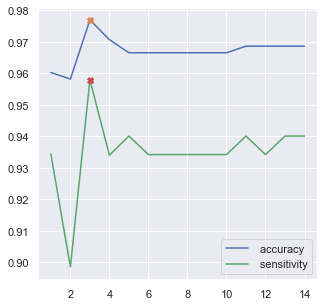

In [30]:
sns.set(rc={'figure.figsize':(5, 5)})

knn = KNeighborsClassifier()
params = {'n_neighbors': range(1, 15)}
folds= 5

cv = GridSearchCV(knn, params, refit=True, cv = folds, 
                  scoring = make_scorer(accuracy))
_ = cv.fit(x_train, y_train)

cv1 = GridSearchCV(knn, params, refit=True, cv = folds, 
                  scoring = make_scorer(sklearn.metrics.recall_score))
_ = cv1.fit(x_train, y_train)

show_results(cv, x_test, "param_n_neighbors", 'accuracy')
show_results(cv1, x_test, "param_n_neighbors", 'sensitivity')

Even in this case, both the GridSearch based on accuracy and the GridSearch based on sensitivity identified the same parameter as best: the fact that its value of K = 3 is low is a further suggestion that a complex boundary is more suitable for the classification of these data.

In [31]:
knn = KNeighborsClassifier(3) 
_ = knn.fit(x_train, y_train)

print("Train accuracy:", accuracy(y_train, knn.predict(x_train)))
print("Train recall:", sklearn.metrics.recall_score(y_train, knn.predict(x_train)))
print("Test accuracy:", accuracy(y_test, knn.predict(x_test)))
print("Test recall:", sklearn.metrics.recall_score(y_test, knn.predict(x_test)))

Train accuracy: 0.9874476987447699
Train recall: 0.9820359281437125
Test accuracy: 0.9560975609756097
Test recall: 0.9444444444444444


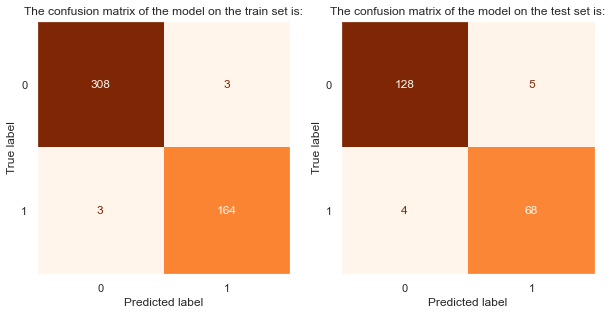

In [32]:
sns.set(rc={'figure.figsize':(10, 10)})

cm = confusion_matrix(y_test, knn.predict(x_test))

# train confusion matrix

ax1 = plt.subplot(1,2,1)

_ = plt.title(f'The confusion matrix of the model on the train set is:')
_ = plot_confusion_matrix(knn, x_train, y_train, ax = ax1, colorbar = False, cmap= 'Oranges')
plt.grid(False)

# test confusion matrix

ax2 = plt.subplot(1,2,2)
_ = plt.title(f'The confusion matrix of the model on the test set is:')
_ = plot_confusion_matrix(knn, x_test, y_test, ax = ax2, colorbar = False, cmap= 'Oranges')
plt.grid(False)

Still, the sensitivity on the test set might be improved.

## SUPPORT VECTOR MACHINES ##

Generally speaking, most of classification algorithms are optimized to find boundaries or lines that divide points in the feature space. However, if the data is really linearly separable, then there will exist an infinite number of separating lines. The issue is choosing the best line among all: the maximal margin hyperplane, which is the hyperplane that has the farthest minimum distance from the training observations - that's to say, has the largest margin from the observations. 
The Support Vector Machines are a class of classifiers that generalize this simple intuition to apply it in a wide range of classification problems.  

### HARD MARGINS - LINEARLY SEPARABLE CASE ###

When a perfeclty separating hyperplane exists, the Maximal Margin Classifier is able to find a robust and precise approximation compared to the other methods, because it finds the boundary which is farthest from the obervations, ensuring their correct classification even in the presence of noise. 

However, when I tried to fit this SVM model with hard margins:

In [33]:
# model = SVC(kernel= 'linear', C= np.inf) 
# model.fit(x_train, y_train)

the algorithm never found a solution, providing the final demonstration that the data is not perfectly linearly separable.

### SOFT MARGINS - NON LINEARLY SEPARABLE CASE ### 

When no separating hyperplane exists, it is needed to allow some missclassified points to make a good classification of the remaining observations. This can be done by the Support Vector Classifier: this algorithm introduces a slack variable to the optimization problem, which allows individual observations to be on the wrong side of the margin, and a cost parameter C, that handles the number of tolerated missclassifications, while still allowing the boundary to be linear: the lower the C, the more important the slack variable is in the function, and therefore more points are allowed to be missclassified. This is why I put C as infinite in the previous case: I didn't want to consider the slack variable, because I didn't want to allow any error. 

The tuning parameter in this case is the cost parameter C, that once again can be identified by GridSearch and cross-validation:

In [34]:
param_grid = {'C': np.linspace(0.001, 100, 5)}

cv = GridSearchCV(SVC(kernel='linear'), param_grid,
                        cv=5, scoring=make_scorer(accuracy), refit=True)
_ = cv.fit(x_train, y_train)

cv1 = GridSearchCV(SVC(kernel='linear'), param_grid,
                        cv=5, scoring=make_scorer(sklearn.metrics.recall_score), refit=True)
_ = cv1.fit(x_train, y_train)

print(f'The best estimator by accuracy is {cv.best_estimator_}')
print(f'The best estimator by sensitivity is {cv1.best_estimator_}')

The best estimator by accuracy is SVC(C=0.001, kernel='linear')
The best estimator by sensitivity is SVC(C=25.00075, kernel='linear')


In this case, the GridSearch based on accuracy and the GridSearch based on sensitivity provided two different parameters.
To pick the best C between the two, since they were chosen based on a CV score computed by a single metric not considering the other (and therefore, the CV scores alone were not comparable), I decided to fit two models with both the selected parameters and choose the best one based on a complete overview of their performances on the test set and on the validation sets, in order to avoid any possible chance of overfitting:

sensitivity CV accuracy score: 0.9644, CV recall score: 0.9583, test accuracy score: 0.9610, test recall score: 0.9583
accuracy CV accuracy score: 0.9602, CV recall score: 0.9403, test accuracy score: 0.9561, test recall score: 0.9444


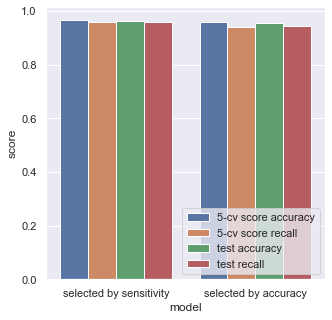

In [35]:
cv_score_accuracy, cv_score_recall, test_scores, test_scores_r = [], [], [], []
models = [('sensitivity', cv1), ('accuracy', cv)]
sns.set(rc={'figure.figsize':(5, 5)})
for name, model in models:
    
    cv_acc = cross_val_score(model, x_train, y_train, cv=folds, scoring = make_scorer(accuracy)) 
    cv_score_a = np.mean(cv_acc)
    cv_score_accuracy.append(cv_score_a)
    cv_rec = cross_val_score(model, x_train, y_train, cv=folds, scoring = make_scorer(sklearn.metrics.recall_score)) 
    cv_score_r = np.mean(cv_rec)
    cv_score_recall.append(cv_score_r)
    
    test_score = accuracy(y_test, model.predict(x_test))
    test_score_r = sklearn.metrics.recall_score(y_test, model.predict(x_test))
    test_scores.append(test_score)
    test_scores_r.append(test_score_r)
    print("\033[1m{}\033[0m CV accuracy score: {:.4f}, CV recall score: {:.4f}, test accuracy score: {:.4f}, test recall score: {:.4f}".format(name, cv_score_a, cv_score_r, test_score, test_score_r))

data = pd.DataFrame()
data['model'] = ['selected by sensitivity', 'selected by accuracy'] * 4
data['metric'] = ['5-cv score accuracy'] * len(cv_score_accuracy) + ['5-cv score recall'] * len(cv_score_recall) + ['test accuracy'] * len(test_scores) + ['test recall'] * len(test_scores_r) 
data['score'] = cv_score_accuracy + cv_score_recall + test_scores + test_scores_r 

_ = sns.barplot(x='model', y='score', data=data, hue='metric')
_ = plt.legend(loc='lower right')

Once again, the most performing parameter was determined by the sensitivity metric:

In [36]:
svm_lin = SVC(C=25.00075, kernel='linear')
_ = svm_lin.fit(x_train, y_train)

print("Train accuracy:", accuracy(y_train, svm_lin.predict(x_train)))
print("Train recall:", sklearn.metrics.recall_score(y_train, svm_lin.predict(x_train)))
print("Test accuracy:", accuracy(y_test, svm_lin.predict(x_test)))
print("Test recall:", sklearn.metrics.recall_score(y_test, svm_lin.predict(x_test)))

Train accuracy: 0.9769874476987448
Train recall: 0.9700598802395209
Test accuracy: 0.9609756097560975
Test recall: 0.9583333333333334


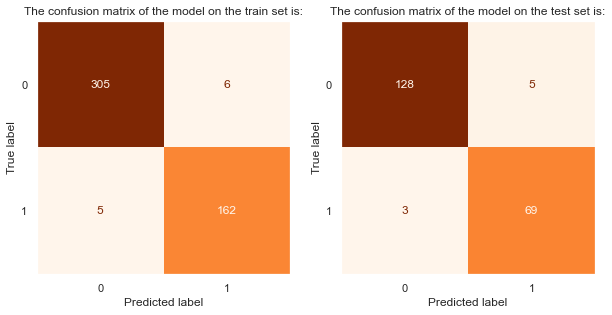

In [37]:
sns.set(rc={'figure.figsize':(10, 10)})

cm = confusion_matrix(y_test, svm_lin.predict(x_test))

# train confusion matrix

ax1 = plt.subplot(1,2,1)

_ = plt.title(f'The confusion matrix of the model on the train set is:')
_ = plot_confusion_matrix(svm_lin, x_train, y_train, ax = ax1, colorbar = False, cmap= 'Oranges')
plt.grid(False)

# test confusion matrix

ax2 = plt.subplot(1,2,2)
_ = plt.title(f'The confusion matrix of the model on the test set is:')
_ = plot_confusion_matrix(svm_lin, x_test, y_test, ax = ax2, colorbar = False, cmap= 'Oranges')
plt.grid(False)

Then, I investigated if a model accounting for a strongly non-linear boundary was better for this classification problem.

### THE SUPPORT VECTOR MACHINE ### 

The Support Vector Machine is an extension of the Support Vector Classifier, that enlarges the feature space in order to accomodate non-linear boundary between classes (if projected into the original feature space, while the boundary is still linear in the enlarged space) and therefore more flexible models: this is done by using kernels, which are computational approaches that are able to realize this procedure. They essentially allow to fit a Support Vector Classifier in a higher-dimensional space involving polynomials of different degrees: when the degree is equal to 1, the feature space is the original one and the SVM is equal to the SVC.

I employed three different kernel functions:

- Radial Basis Function Kernel
- Polynomial Kernel
- Sigmoid Kernel

and investigated which was the one that allowed the most precise division of the classes thanks to GridSearch and cross-validation:

In [38]:
# Polynomial

param_grid = {'C': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4]}
cv_poly = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=5, scoring=make_scorer(accuracy), refit=True)

cv1_poly = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=5, scoring=make_scorer(sklearn.metrics.recall_score), refit=True)

# RBF

param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
cv_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=5, scoring=make_scorer(accuracy), refit=True)

cv1_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=5, scoring=make_scorer(sklearn.metrics.recall_score), refit=True)

# Sigmoid

param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
cv_sigm = GridSearchCV(SVC(kernel='sigmoid'), param_grid, 
                         cv=5, scoring=make_scorer(accuracy), refit=True)

cv1_sigm = GridSearchCV(SVC(kernel='sigmoid'), param_grid, 
                         cv=5, scoring=make_scorer(sklearn.metrics.recall_score), refit=True)

In [39]:
models = [('svm_poly by sensitivity', cv1_poly), ('svm_poly by accuracy', cv_poly), ('rbf_poly by sensitivity', cv1_rbf), ('rbf_poly by accuracy', cv_rbf), ('sigm_poly by sensitivity', cv1_sigm), ('sigm_poly by accuracy', cv_sigm)]

for name, m in models:
    _ = m.fit(x_train, y_train)
    cv_score = m.best_score_
    m = m.best_estimator_
    print(f'The best parameters for \033[1m{name}\033[0m are {m}')

    train_acc = accuracy(y_train, m.predict(x_train))
    test_acc = accuracy(y_test, m.predict(x_test))
    print("cv score: {}".format(cv_score))
    print("train accuracy score: {}".format(train_acc))
    print("train recall score: {}".format(sklearn.metrics.recall_score(y_train, m.predict(x_train))))
    print("test accuracy score: {}".format(test_acc))
    print("test recall score: {}\n".format(sklearn.metrics.recall_score(y_test, m.predict(x_test))))

The best parameters for svm_poly by sensitivity are SVC(C=0.001, coef0=-10.0, kernel='poly')
cv score: 0.9582887700534759
train accuracy score: 0.9539748953974896
train recall score: 0.9461077844311377
test accuracy score: 0.9609756097560975
test recall score: 0.9583333333333334

The best parameters for svm_poly by accuracy are SVC(C=0.001, coef0=5.0, degree=4, kernel='poly')
cv score: 0.9728070175438596
train accuracy score: 0.9790794979079498
train recall score: 0.9640718562874252
test accuracy score: 0.9560975609756097
test recall score: 0.9444444444444444

The best parameters for rbf_poly by sensitivity are SVC(C=25.00075, gamma=0.001)
cv score: 0.9581105169340465
train accuracy score: 0.9811715481171548
train recall score: 0.9700598802395209
test accuracy score: 0.9609756097560975
test recall score: 0.9583333333333334

The best parameters for rbf_poly by accuracy are SVC(C=25.00075, gamma=0.001)
cv score: 0.9728070175438596
train accuracy score: 0.9811715481171548
train recall sco

svm_poly by sensitivity CV accuracy score: 0.9665, CV recall score: 0.9642, test accuracy score: 0.9610, test recall score: 0.9583
svm_poly by accuracy CV accuracy score: 0.9665, CV recall score: 0.9581, test accuracy score: 0.9561, test recall score: 0.9444
rbf_poly by sensitivity CV accuracy score: 0.9041, CV recall score: 0.9702, test accuracy score: 0.9610, test recall score: 0.9583
rbf_poly by accuracy CV accuracy score: 0.9728, CV recall score: 0.9581, test accuracy score: 0.9610, test recall score: 0.9583
sigm_poly by sensitivity CV accuracy score: 0.9728, CV recall score: 0.9581, test accuracy score: 0.9610, test recall score: 0.9583
sigm_poly by accuracy CV accuracy score: 0.9728, CV recall score: 0.9581, test accuracy score: 0.9610, test recall score: 0.9583


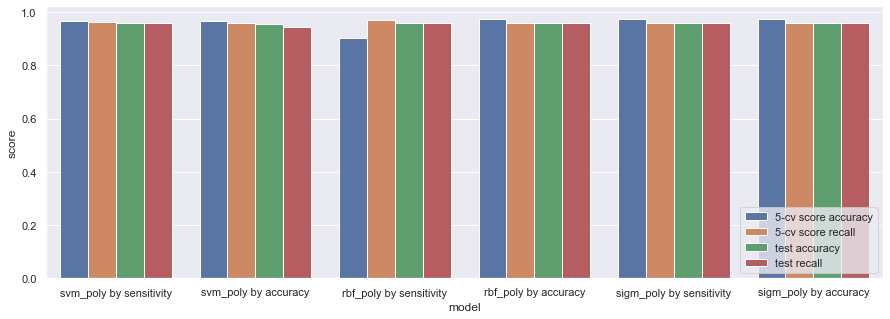

In [40]:
sns.set(rc={'figure.figsize':(15, 5)})
cv_score_accuracy, cv_score_recall, test_scores, test_scores_r = [], [], [], []
for name, model in models:
    
    cv_acc = cross_val_score(model, x_train, y_train, cv=folds, scoring = make_scorer(accuracy)) 
    cv_score_a = np.mean(cv_acc)
    cv_score_accuracy.append(cv_score_a)
    cv_rec = cross_val_score(model, x_train, y_train, cv=folds, scoring = make_scorer(sklearn.metrics.recall_score)) 
    cv_score_r = np.mean(cv_rec)
    cv_score_recall.append(cv_score_r)
    
    test_score = accuracy(y_test, model.predict(x_test))
    test_score_r = sklearn.metrics.recall_score(y_test, model.predict(x_test))
    test_scores.append(test_score)
    test_scores_r.append(test_score_r)
    print("\033[1m{}\033[0m CV accuracy score: {:.4f}, CV recall score: {:.4f}, test accuracy score: {:.4f}, test recall score: {:.4f}".format(name, cv_score_a, cv_score_r, test_score, test_score_r))

data = pd.DataFrame()
data['model'] = ['svm_poly by sensitivity', 'svm_poly by accuracy', 'rbf_poly by sensitivity', 'rbf_poly by accuracy', 'sigm_poly by sensitivity', 'sigm_poly by accuracy'] * 4
data['metric'] = ['5-cv score accuracy'] * len(cv_score_accuracy) + ['5-cv score recall'] * len(cv_score_recall) + ['test accuracy'] * len(test_scores) + ['test recall'] * len(test_scores_r) 
data['score'] = cv_score_accuracy + cv_score_recall + test_scores + test_scores_r 

_ = sns.barplot(x='model', y='score', data=data, hue='metric')
_ = plt.legend(loc='lower right')

Regarding the polynomial kernel, the parameters estimated by sensitivity resulted to be slightly better performing and therefore I decided to keep them. On the other hand, the best parameters estimated for the radial basis function were found by the accuracy metric. Instead, regarding the sigmoid kernel, both metrics agreed on the same model as best.  

In [41]:
svm_poly = cv1_poly
rbf_poly = cv_rbf
sigm_poly = cv_sigm 

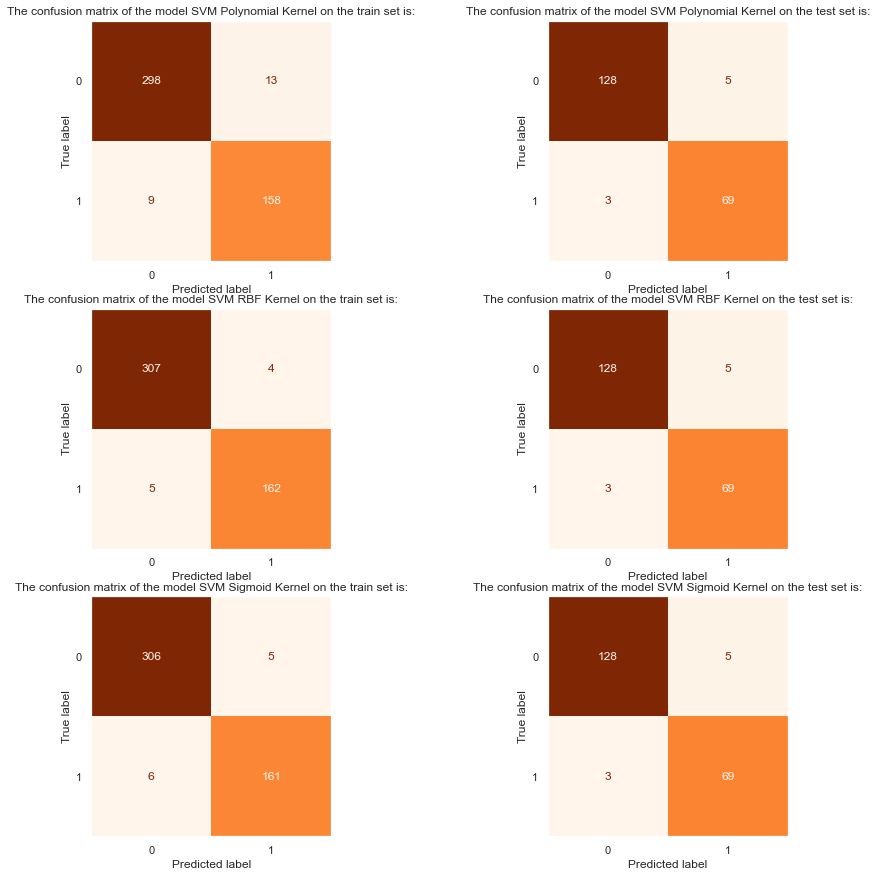

In [42]:
sns.set(rc={'figure.figsize':(15,15)})

n = 1
for model in [('SVM Polynomial Kernel',svm_poly), ('SVM RBF Kernel', rbf_poly), ('SVM Sigmoid Kernel', sigm_poly)]:
    _ = model[1].fit(x_train, y_train)
    cm = confusion_matrix(y_test, model[1].predict(x_test))
    
    ax1 = plt.subplot(3,2,n)
    n +=1
    _ = plt.title(f'The confusion matrix of the model {model[0]} on the train set is:')
    _ = plot_confusion_matrix(model[1], x_train, y_train, ax = ax1, colorbar = False, cmap= 'Oranges')
    plt.grid(False)
    
    ax2 = plt.subplot(3,2,n)
    _ = plt.title(f'The confusion matrix of the model {model[0]} on the test set is:')
    _ = plot_confusion_matrix(model[1], x_test, y_test, ax = ax2, colorbar = False, cmap= 'Oranges')
    plt.grid(False)
    n +=1

Surely the sigmoid and radial kernel had a similar performances on both train and test sets, slightly better than the polynomial especially if considering the results on train.  

# MODEL COMPARISONS #

Finally, I compared all the models obtained during this analysis. 

Since generally the majority of the scores didn't differ much from a model to the other, I decided to take into account also another metric that summarizes the performance of the model both on false positives and false negatives errors: the area (AUC) under the ROC curve.
In fact, especially for algorithms that predict probability values, the assignment to a specific class depends on a threshold value set for the posterior probability, which is usually 0.5 by default. However, depending on the specific context, sometimes it might be better to favour the correct prediction of one class with respect to the other and this is possible by lowering or increasing the threshold. Of course, varying the classifier threshold will make the model biased toward the prediction of one class while missing some samples from the other, making sensitivity increase as specificity (the ability to correctly indentify true negatives) decreases and conversely. To find a good balance between true positive rate (sensitivity) and false positive rate (1-specificity), ROC curves can be employed to display the values of the two types of error at all possible thresholds. 
A good classifier should be placed in the top left corner, providing both a high true positive rate and a low false positive rate: in fact, the overall performance of a classifier, summarized over all possible thresholds, can be obtained by the total area under the curve (AUC) - the higher the curve, the better the performances. 

I therefore plotted a ROC curve for all the models that I had fitted, computed both on train and test sets:

In [43]:
def plot_roc(predict_fn, X, y, label=None):
    fprs, tprs, t = roc_curve(y, predict_fn(X)[:,-1])
    
    # Plot the ROC
    plt.plot(fprs, tprs, label="ROC "+label)
    plt.xlabel("FPR = 1 - specificity")
    plt.ylabel("TPR = sensitivity")
    plt.legend()

In [44]:
# re-fitting the SVM algorithms to enable probabilty estimates

svm_lin = SVC(kernel = 'linear', C = 25.00075, probability = True)
svm_poly = SVC(C=0.001, coef0=-10.0, kernel='poly', probability = True)
rbf_poly = SVC(C=25.00075, gamma=0.001, probability = True)
sigm_poly = SVC(C=25.00075, gamma=0.001, kernel='sigmoid', probability = True)
models = [('Logistic Regression', lr), ('Logistic Regression - Lasso', lr_lasso), ('LDA', lda), ('QDA', qda), ('KNN', knn), ('Linear SVM', svm_lin), ('SVM Polynomial Kernel', svm_poly), ('SVM RBF Kernel', rbf_poly), ('SVM Sigmoid Kernel', sigm_poly)]

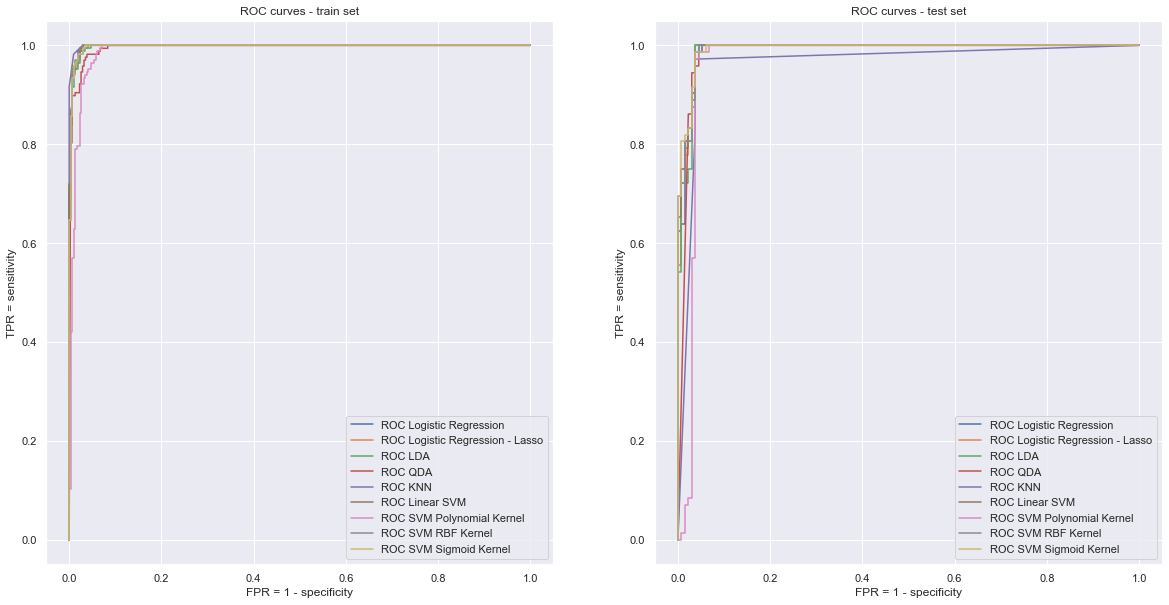

In [45]:
sns.set(rc={'figure.figsize':(20,10)})

for model in models:
    if model[1] == lr_lasso:
        _ = model[1].fit(x_train_l, y_train)
        _ = plt.subplot(1,2,1)
        _ = plot_roc(model[1].predict_proba, x_train_l, y_train, model[0])
    
    else:
        _ = model[1].fit(x_train, y_train)
        _ = plt.subplot(1,2,1)
        _ = plot_roc(model[1].predict_proba, x_train, y_train, model[0])
    _ = plt.title('ROC curves - train set')
    
for model in models:
    if model[1] == lr_lasso:
        _ = model[1].fit(x_train_l, y_train)
        _ = plt.subplot(1,2,2)
        _ = plot_roc(model[1].predict_proba, x_test_l, y_test, model[0])
    
    else:
        _ = model[1].fit(x_train, y_train)
        _ = plt.subplot(1,2,2)
        _ = plot_roc(model[1].predict_proba, x_test, y_test, model[0])
    _ = plt.title('ROC curves - test set')

To have a quantification of this type of evaluation, I also imported a scikit-learn method that is able to compute the area. Also, I computed four barplots for each model showing their cross-validation score over the train accuracy and train sensitivity, their test accuracy, their test sensitivity and their test AUC score, in order to have an overall insight of their performance on the data regarding different types of errors. 

In fact, as I said before, focusing on one single metric can be misleading and it is better to evaluate the performance based on different scores, in order to have a grasp of all possible aspects and to select the model that has the best general trend on all metrics, still giving more weight to the sensitivity score because in this context it is particularly important not to miss a positive patient.

Logistic Regression CV accuracy score: 0.9707, CV recall score: 0.9522, test accuracy score: 0.9561, test recall score: 0.9444 test auc score: 0.9909
Logistic Regression - Lasso CV accuracy score: 0.9728, CV recall score: 0.9583, test accuracy score: 0.9610, test recall score: 0.9583 test auc score: 0.9908
LDA CV accuracy score: 0.9665, CV recall score: 0.9223, test accuracy score: 0.9366, test recall score: 0.8889 test auc score: 0.9896
QDA CV accuracy score: 0.9477, CV recall score: 0.9879, test accuracy score: 0.9561, test recall score: 0.9583 test auc score: 0.9853
KNN CV accuracy score: 0.9770, CV recall score: 0.9579, test accuracy score: 0.9561, test recall score: 0.9444 test auc score: 0.9647
Linear SVM CV accuracy score: 0.9644, CV recall score: 0.9583, test accuracy score: 0.9610, test recall score: 0.9583 test auc score: 0.9918
SVM Polynomial Kernel CV accuracy score: 0.9644, CV recall score: 0.9583, test accuracy score: 0.9610, test recall score: 0.9583 test auc score: 0.96

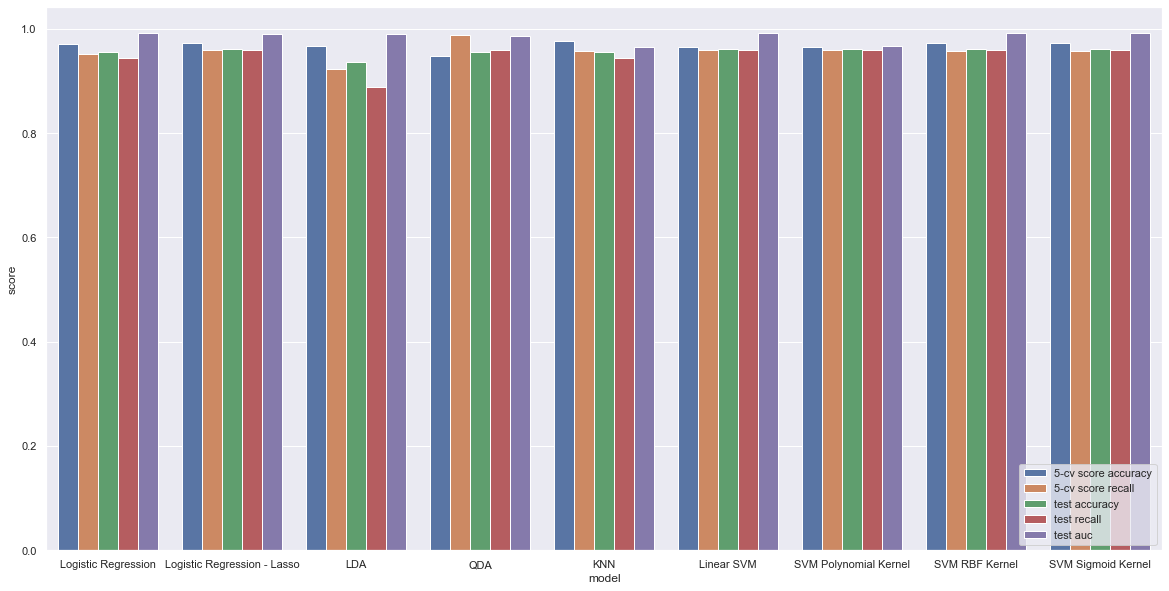

In [46]:
sns.set(rc={'figure.figsize':(20,10)})

models = OrderedDict([('Logistic Regression', lr), ('Logistic Regression - Lasso', lr_lasso), ('LDA', lda), ('QDA', qda), ('KNN', knn), ('Linear SVM', svm_lin), ('SVM Polynomial Kernel', svm_poly), ('SVM RBF Kernel', rbf_poly), ('SVM Sigmoid Kernel', sigm_poly)])

cv_score_accuracy, cv_score_recall, test_scores, test_scores_r, auc_scores = [], [], [], [], []
for name, model in models.items():
    if model == lr_lasso:
        
        cv_acc = cross_val_score(model, x_train_l, y_train, cv=folds, scoring = make_scorer(accuracy)) 
        cv_score_a = np.mean(cv_acc)
        cv_score_accuracy.append(cv_score_a)
        cv_rec = cross_val_score(model, x_train_l, y_train, cv=folds, scoring = make_scorer(sklearn.metrics.recall_score)) 
        cv_score_r = np.mean(cv_rec)
        cv_score_recall.append(cv_score_r)
        
        #_ = model.fit(x_train, y_train) 
    
        test_score = accuracy(y_test, model.predict(x_test_l))
        test_score_r = sklearn.metrics.recall_score(y_test, model.predict(x_test_l))
        auc_score = roc_auc_score(y_test, model.predict_proba(x_test_l)[:,1])
    
    else:
        
        cv_acc = cross_val_score(model, x_train, y_train, cv=folds, scoring = make_scorer(accuracy)) 
        cv_score_a = np.mean(cv_acc)
        cv_score_accuracy.append(cv_score_a)
        cv_rec = cross_val_score(model, x_train, y_train, cv=folds, scoring = make_scorer(sklearn.metrics.recall_score)) 
        cv_score_r = np.mean(cv_rec)
        cv_score_recall.append(cv_score_r)
        
        #_ = model.fit(x_train, y_train) 
    
        test_score = accuracy(y_test, model.predict(x_test))
        test_score_r = sklearn.metrics.recall_score(y_test, model.predict(x_test))
        auc_score = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
        
    test_scores.append(test_score)
    test_scores_r.append(test_score_r)
    auc_scores.append(auc_score)
    print("\033[1m{}\033[0m CV accuracy score: {:.4f}, CV recall score: {:.4f}, test accuracy score: {:.4f}, test recall score: {:.4f} test auc score: {:.4f}".format(name, cv_score_a, cv_score_r, test_score, test_score_r, auc_score))

data = pd.DataFrame()
data['model'] = list(models.keys()) * 5
data['metric'] = ['5-cv score accuracy'] * len(cv_score_accuracy) + ['5-cv score recall'] * len(cv_score_recall) + ['test accuracy'] * len(test_scores) + ['test recall'] * len(test_scores_r) + ['test auc'] * len(auc_scores)
data['score'] = cv_score_accuracy + cv_score_recall + test_scores + test_scores_r + auc_scores

_ = sns.barplot(x='model', y='score', data=data, hue='metric')
_ = plt.legend(loc='lower right')

# CONCLUSIONS # 

In conclusion, even though the data is surely complex and the classes are not perfectly linear separable - as was confirmed by the non-converging Maximal Margin Classifier algorithm - all the fitted classifiers had good performances. In my opinion, this means that the points which are missclassified by a linear classifier are not many compared to the others, and also that the data that was not really far from the assumptions of any of the models. However, if I needed to pick a single model among all the ones computed, I think it would be better to discard all the models that rely on assumptions that are not adequate for this dataset, such as Logistic Regression and LDA, that rely on linearity. Regarding the remaining models, since all of them have good overall performances, I would say that the best for this clinical context is QDA since is the one with a considerably higher sensitivity cross-validation score, and therefore is the one that misses the least number of true positives in the prediction. The QDA model is also the one that has the lowest accuracy cross-validation score, but given that it is the one with the highest recall, it is explained by the fact that it probably predicts more false positives compared to the other models. However, its test accuracy and AUC scores are still sufficiently high (even if might be lower with respect to some other models), and the CV accuracy score itself is not low at all; therefore this little amount of false positives (that can be easily demonstrated to be negative by further medical analyses) is a worthy price to pay to catch the highest possible number of true positives.  